In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import random
import math
import time
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator
plt.style.use('seaborn')
%matplotlib inline 

In [4]:
confirmed_cases = pd.read_csv('time_series_covid-19_confirmed.csv')

In [5]:
deaths_reported = pd.read_csv('time_series_covid-19_deaths.csv')

In [6]:
recovered_cases = pd.read_csv('time_series_covid-19_recovered.csv')

In [7]:
cols = confirmed_cases.keys()

In [8]:
confirmed = confirmed_cases.loc[:, cols[4]:cols[-1]]
deaths = deaths_reported.loc[:, cols[4]:cols[-1]]
recoveries = recovered_cases.loc[:, cols[4]:cols[-1]]

In [9]:
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
total_recovered = [] 

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    mortality_rate.append(death_sum/confirmed_sum)
    total_recovered.append(recovered_sum)

In [10]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

In [11]:
days_in_future = 10
future_forecast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forecast[:-10]

In [12]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forecast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [43]:
future_forcast_dates

['01/22/2020',
 '01/23/2020',
 '01/24/2020',
 '01/25/2020',
 '01/26/2020',
 '01/27/2020',
 '01/28/2020',
 '01/29/2020',
 '01/30/2020',
 '01/31/2020',
 '02/01/2020',
 '02/02/2020',
 '02/03/2020',
 '02/04/2020',
 '02/05/2020',
 '02/06/2020',
 '02/07/2020',
 '02/08/2020',
 '02/09/2020',
 '02/10/2020',
 '02/11/2020',
 '02/12/2020',
 '02/13/2020',
 '02/14/2020',
 '02/15/2020',
 '02/16/2020',
 '02/17/2020',
 '02/18/2020',
 '02/19/2020',
 '02/20/2020',
 '02/21/2020',
 '02/22/2020',
 '02/23/2020',
 '02/24/2020',
 '02/25/2020',
 '02/26/2020',
 '02/27/2020',
 '02/28/2020',
 '02/29/2020',
 '03/01/2020',
 '03/02/2020',
 '03/03/2020',
 '03/04/2020',
 '03/05/2020',
 '03/06/2020',
 '03/07/2020',
 '03/08/2020',
 '03/09/2020',
 '03/10/2020',
 '03/11/2020',
 '03/12/2020',
 '03/13/2020',
 '03/14/2020',
 '03/15/2020',
 '03/16/2020',
 '03/17/2020',
 '03/18/2020',
 '03/19/2020',
 '03/20/2020',
 '03/21/2020',
 '03/22/2020',
 '03/23/2020',
 '03/24/2020',
 '03/25/2020']

In [13]:
latest_confirmed = confirmed_cases[dates[-1]]
latest_deaths = deaths_reported[dates[-1]]
latest_recoveries = recovered_cases[dates[-1]]

In [14]:
unique_countries =  list(confirmed_cases['Country/Region'].unique())

In [15]:
country_confirmed_cases = []
no_cases = []
for i in unique_countries:
    cases = latest_confirmed[confirmed_cases['Country/Region']==i].sum()
    if cases > 0:
        country_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
        
for i in no_cases:
    unique_countries.remove(i)
    
unique_countries = [k for k, v in sorted(zip(unique_countries, country_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_countries)):
    country_confirmed_cases[i] = latest_confirmed[confirmed_cases['Country/Region']==unique_countries[i]].sum()

In [16]:
print('Confirmed Cases by Countries/Regions:')
for i in range(len(unique_countries)):
    print(f'{unique_countries[i]}: {country_confirmed_cases[i]} cases')

Confirmed Cases by Countries/Regions:
China: 81003 cases
Italy: 24747 cases
Iran: 13938 cases
Korea, South: 8162 cases
Spain: 7798 cases
Germany: 5795 cases
France: 4513 cases
US: 3499 cases
Switzerland: 2200 cases
Norway: 1221 cases
United Kingdom: 1144 cases
Netherlands: 1135 cases
Sweden: 1022 cases
Belgium: 886 cases
Denmark: 875 cases
Austria: 860 cases
Japan: 839 cases
Cruise Ship: 696 cases
Malaysia: 428 cases
Qatar: 401 cases
Greece: 331 cases
Australia: 297 cases
Czechia: 253 cases
Canada: 252 cases
Israel: 251 cases
Portugal: 245 cases
Finland: 244 cases
Singapore: 226 cases
Slovenia: 219 cases
Bahrain: 214 cases
Estonia: 171 cases
Iceland: 171 cases
Brazil: 162 cases
Philippines: 140 cases
Romania: 131 cases
Ireland: 129 cases
Poland: 119 cases
Indonesia: 117 cases
Iraq: 116 cases
Thailand: 114 cases
India: 113 cases
Kuwait: 112 cases
Egypt: 110 cases
Lebanon: 110 cases
Saudi Arabia: 103 cases
San Marino: 101 cases
United Arab Emirates: 98 cases
Chile: 74 cases
Russia: 63 ca

In [17]:
unique_provinces =  list(confirmed_cases['Province/State'].unique())
# those are countries, which are not provinces/states.
outliers = ['United Kingdom', 'Denmark', 'France']
for i in outliers:
    unique_provinces.remove(i)

In [18]:
province_confirmed_cases = []
no_cases = [] 
for i in unique_provinces:
    cases = latest_confirmed[confirmed_cases['Province/State']==i].sum()
    if cases > 0:
        province_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
for i in no_cases:
    unique_provinces.remove(i)

In [19]:
for i in range(len(unique_provinces)):
    print(f'{unique_provinces[i]}: {province_confirmed_cases[i]} cases')

British Columbia: 73 cases
New South Wales: 134 cases
Victoria: 57 cases
Queensland: 61 cases
South Australia: 20 cases
Western Australia: 17 cases
Tasmania: 6 cases
Northern Territory: 1 cases
Ontario: 104 cases
Alberta: 39 cases
Quebec: 24 cases
Washington: 643 cases
New York: 732 cases
California: 426 cases
Massachusetts: 164 cases
Diamond Princess: 742 cases
Grand Princess: 23 cases
Georgia: 99 cases
Colorado: 131 cases
Florida: 115 cases
New Jersey: 98 cases
Oregon: 36 cases
Texas: 72 cases
Illinois: 93 cases
Pennsylvania: 66 cases
Iowa: 18 cases
Maryland: 32 cases
North Carolina: 33 cases
South Carolina: 28 cases
Tennessee: 39 cases
Virginia: 45 cases
Arizona: 13 cases
Indiana: 20 cases
Kentucky: 20 cases
District of Columbia: 16 cases
Nevada: 24 cases
New Hampshire: 13 cases
Minnesota: 35 cases
Nebraska: 17 cases
Ohio: 37 cases
Rhode Island: 20 cases
Wisconsin: 32 cases
Connecticut: 24 cases
Hawaii: 6 cases
Oklahoma: 7 cases
Utah: 28 cases
Kansas: 8 cases
Louisiana: 91 cases
Mis

In [20]:
nan_indices = [] 


for i in range(len(unique_provinces)):
    if type(unique_provinces[i]) == float:
        nan_indices.append(i)

unique_provinces = list(unique_provinces)
province_confirmed_cases = list(province_confirmed_cases)

for i in nan_indices:
    unique_provinces.pop(i)
    province_confirmed_cases.pop(i)

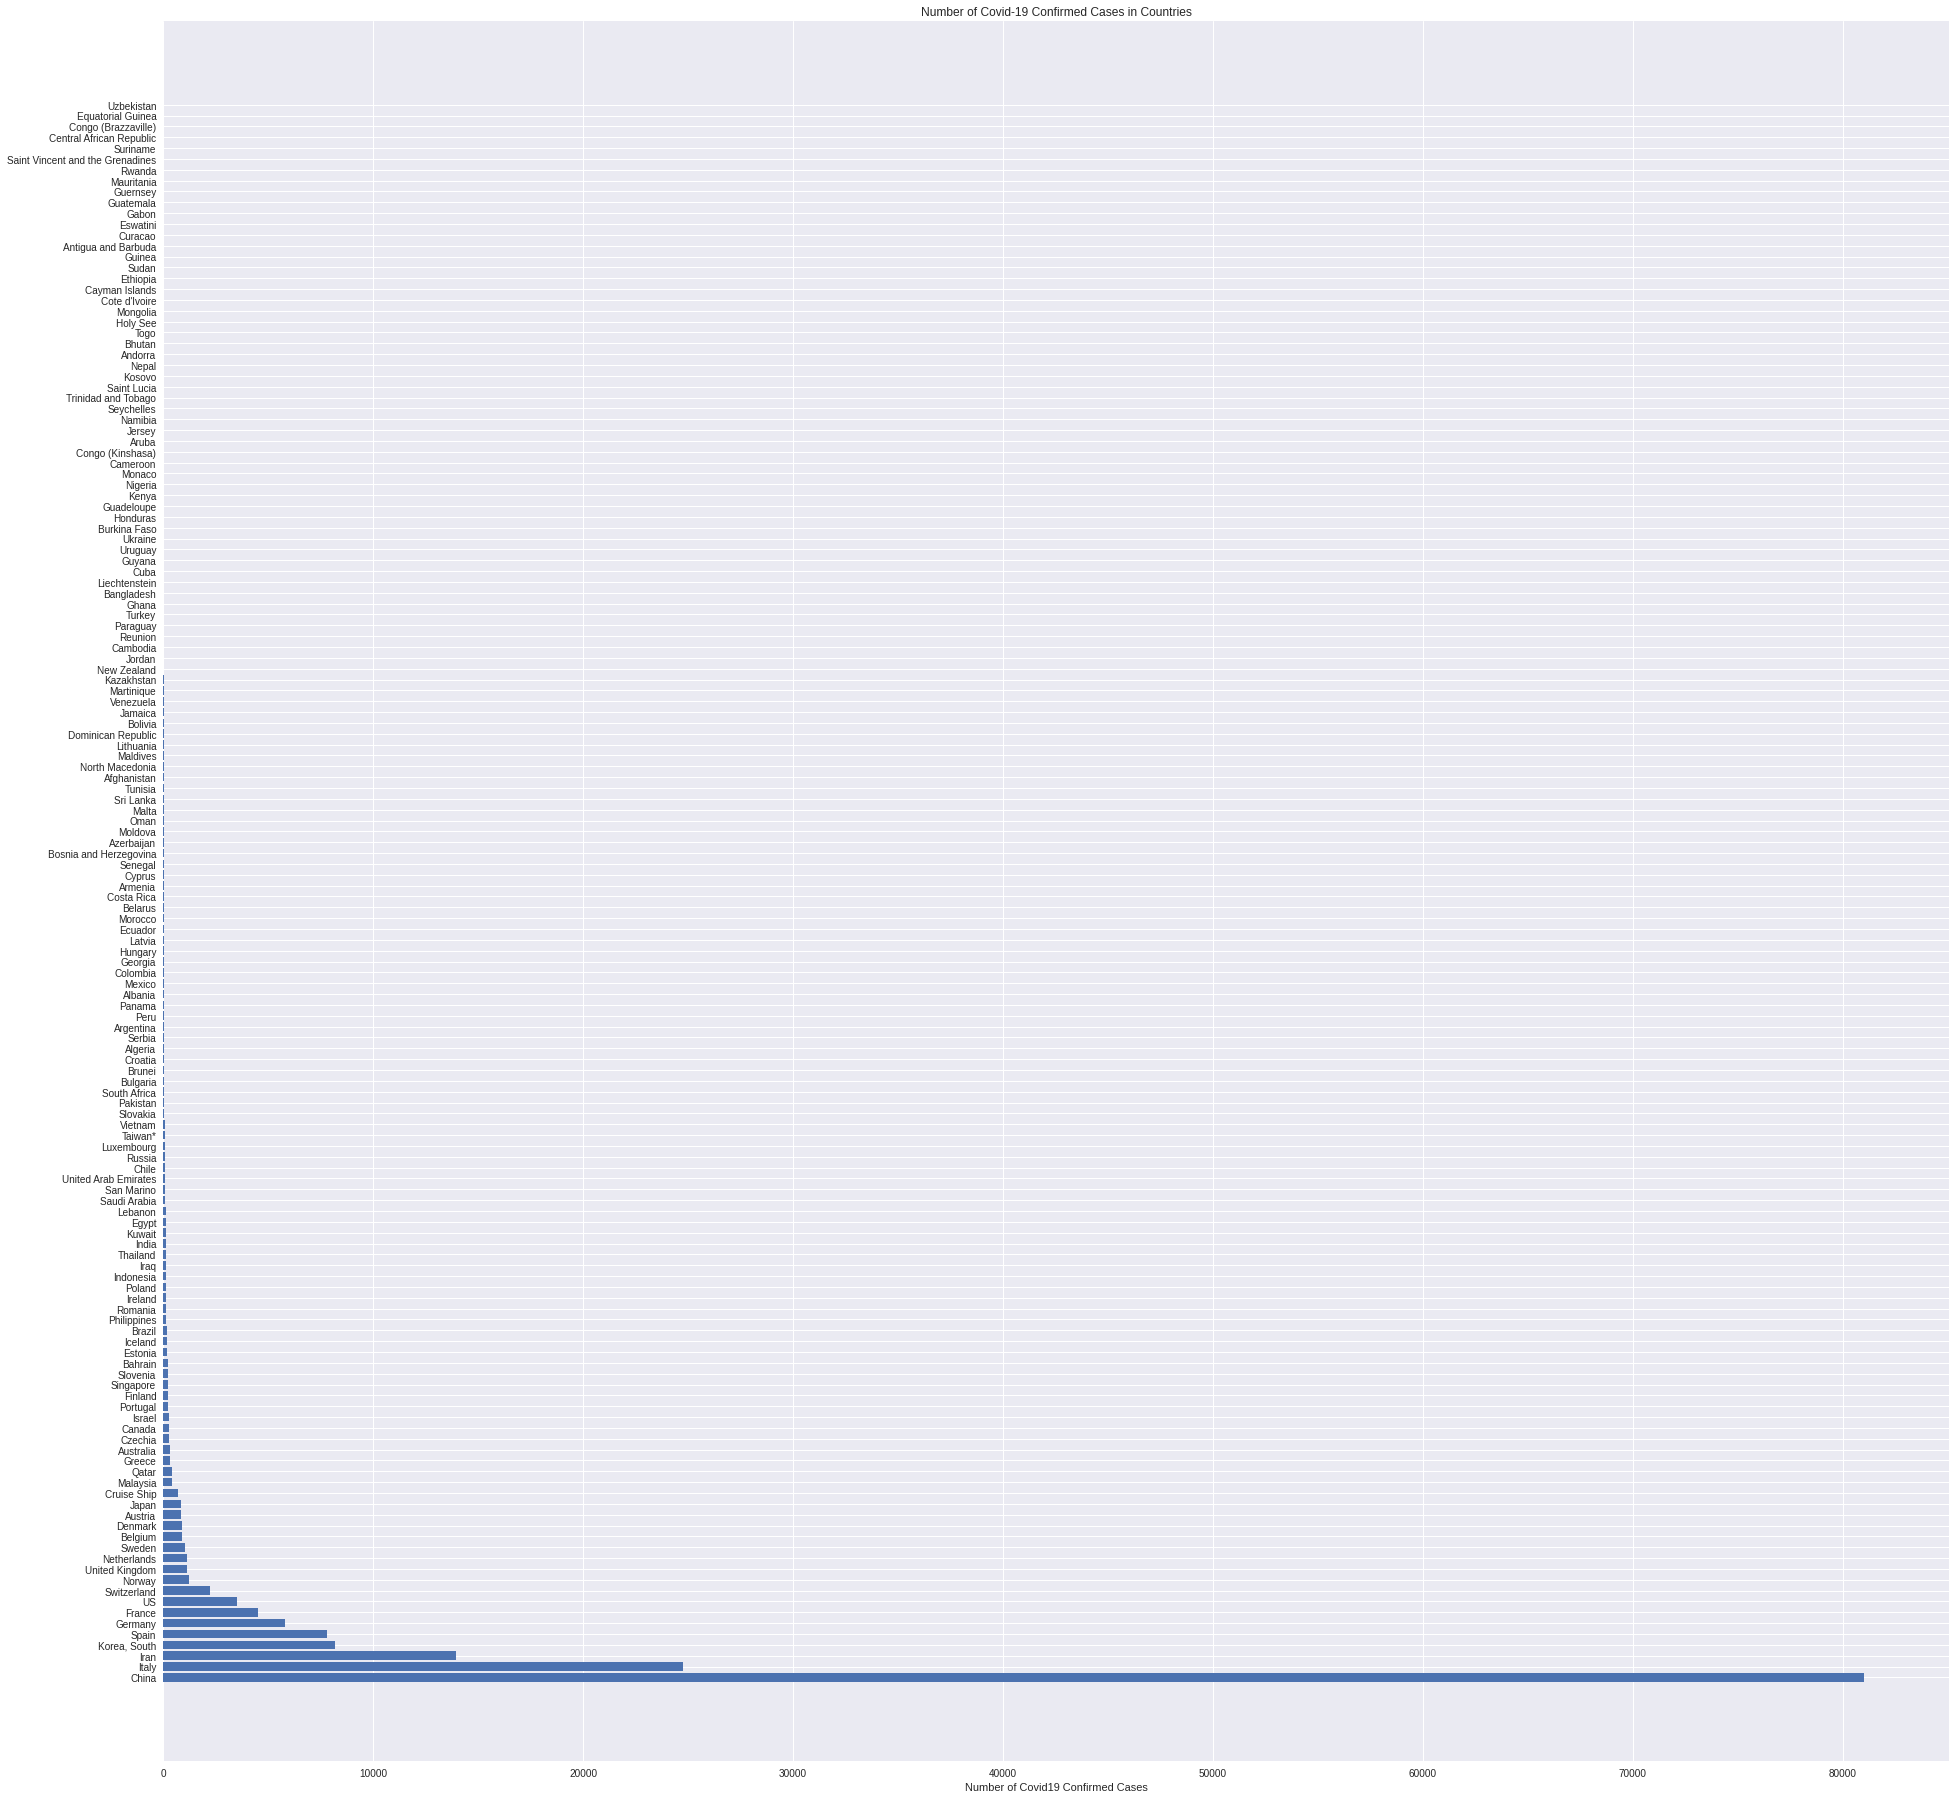

In [21]:
plt.figure(figsize=(32, 32))
plt.barh(unique_countries, country_confirmed_cases)
plt.title('Number of Covid-19 Confirmed Cases in Countries')
plt.xlabel('Number of Covid19 Confirmed Cases')
plt.show()

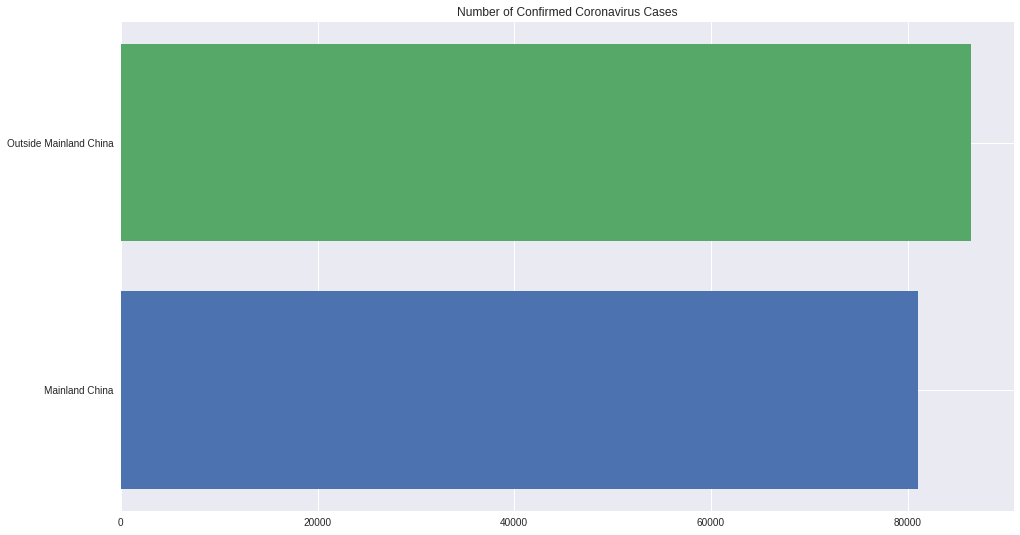

In [22]:
china_confirmed = latest_confirmed[confirmed_cases['Country/Region']=='China'].sum()
outside_mainland_china_confirmed = np.sum(country_confirmed_cases) - china_confirmed
plt.figure(figsize=(16, 9))
plt.barh('Mainland China', china_confirmed)
plt.barh('Outside Mainland China', outside_mainland_china_confirmed)
plt.title('Number of Confirmed Coronavirus Cases')
plt.show()

In [23]:
print('Outside Mainland China {} cases:'.format(outside_mainland_china_confirmed))
print('Mainland China: {} cases'.format(china_confirmed))
print('Total: {} cases'.format(china_confirmed+outside_mainland_china_confirmed))

Outside Mainland China 86446 cases:
Mainland China: 81003 cases
Total: 167449 cases


In [24]:
visual_unique_countries = [] 
visual_confirmed_cases = []
others = np.sum(country_confirmed_cases[10:])
for i in range(len(country_confirmed_cases[:10])):
    visual_unique_countries.append(unique_countries[i])
    visual_confirmed_cases.append(country_confirmed_cases[i])

visual_unique_countries.append('Others')
visual_confirmed_cases.append(others)

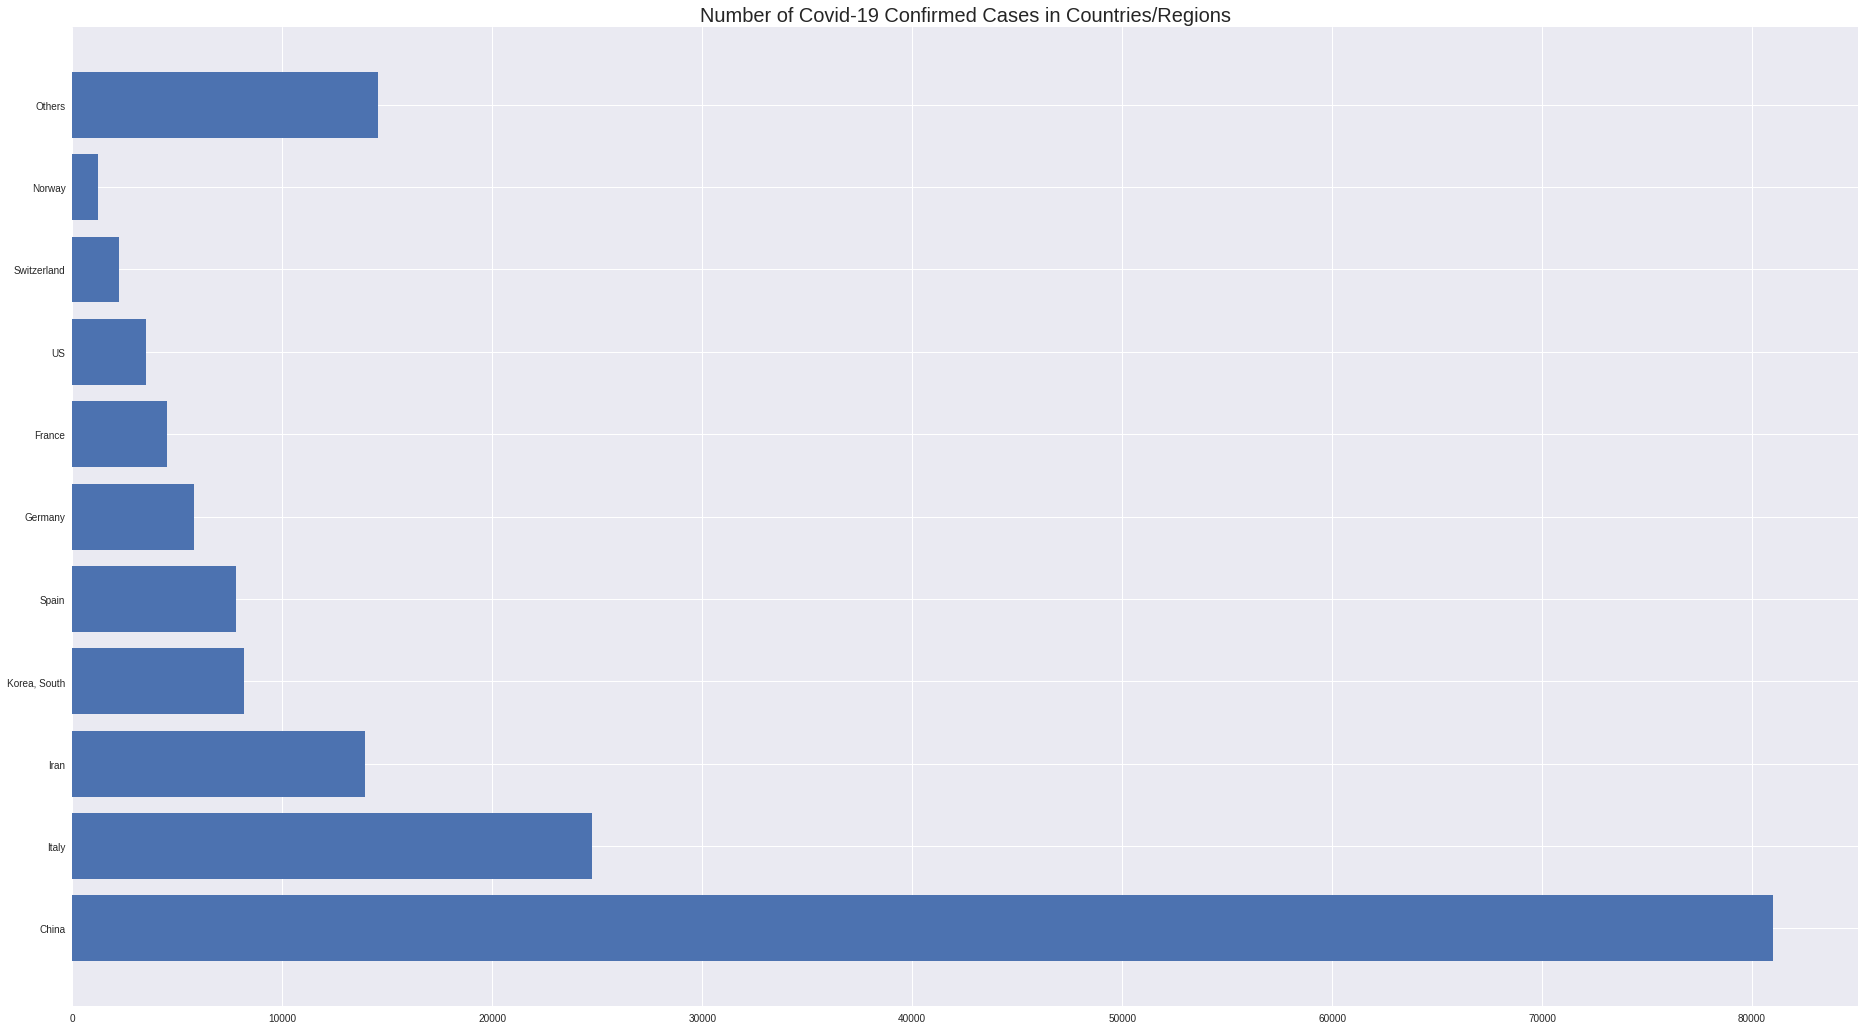

In [25]:
plt.figure(figsize=(32, 18))
plt.barh(visual_unique_countries, visual_confirmed_cases)
plt.title('Number of Covid-19 Confirmed Cases in Countries/Regions', size=20)
plt.show()

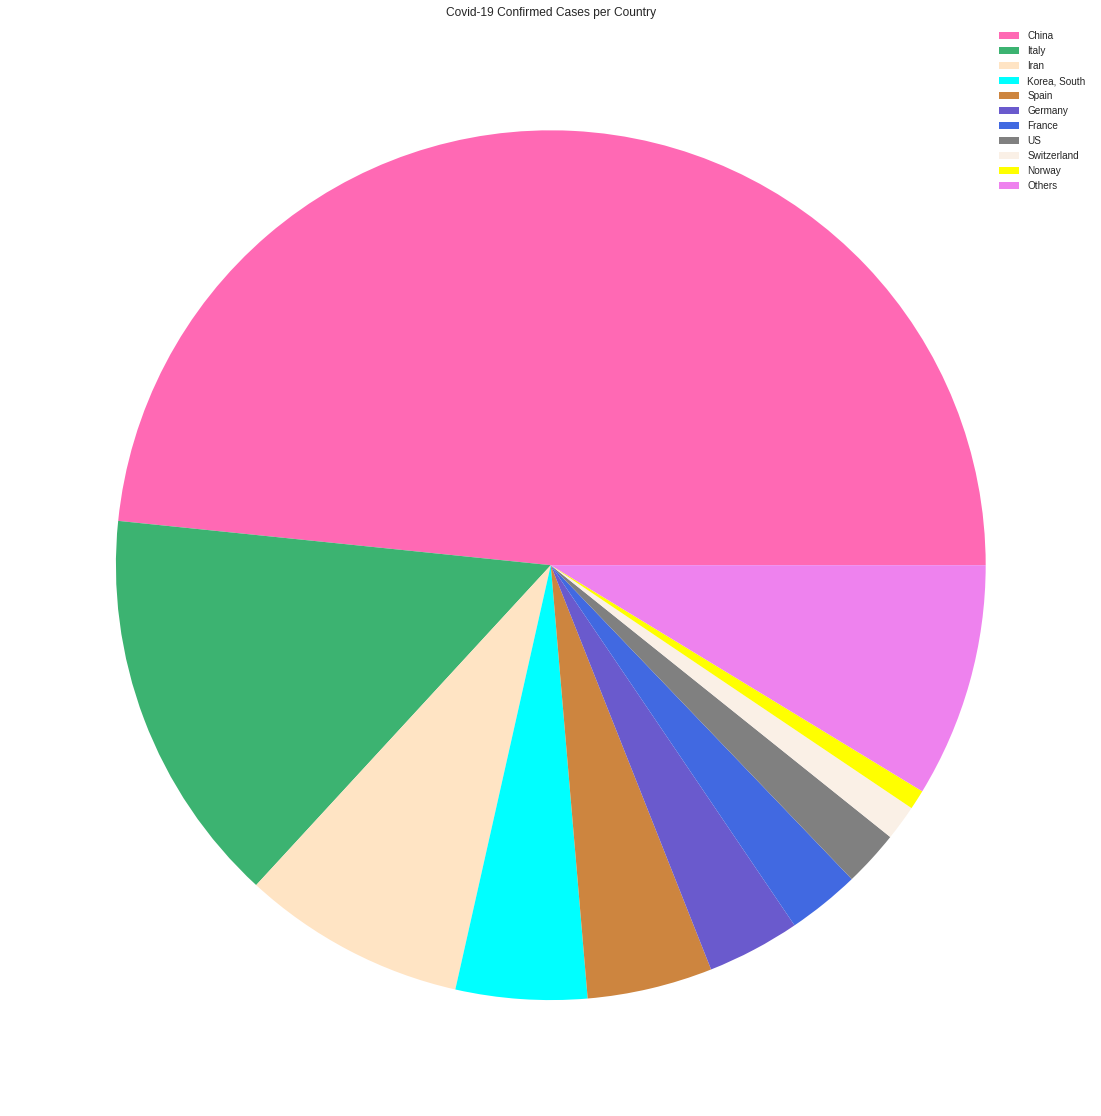

In [26]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,20))
plt.title('Covid-19 Confirmed Cases per Country')
plt.pie(visual_confirmed_cases, colors=c)
plt.legend(visual_unique_countries, loc='best')
plt.show()

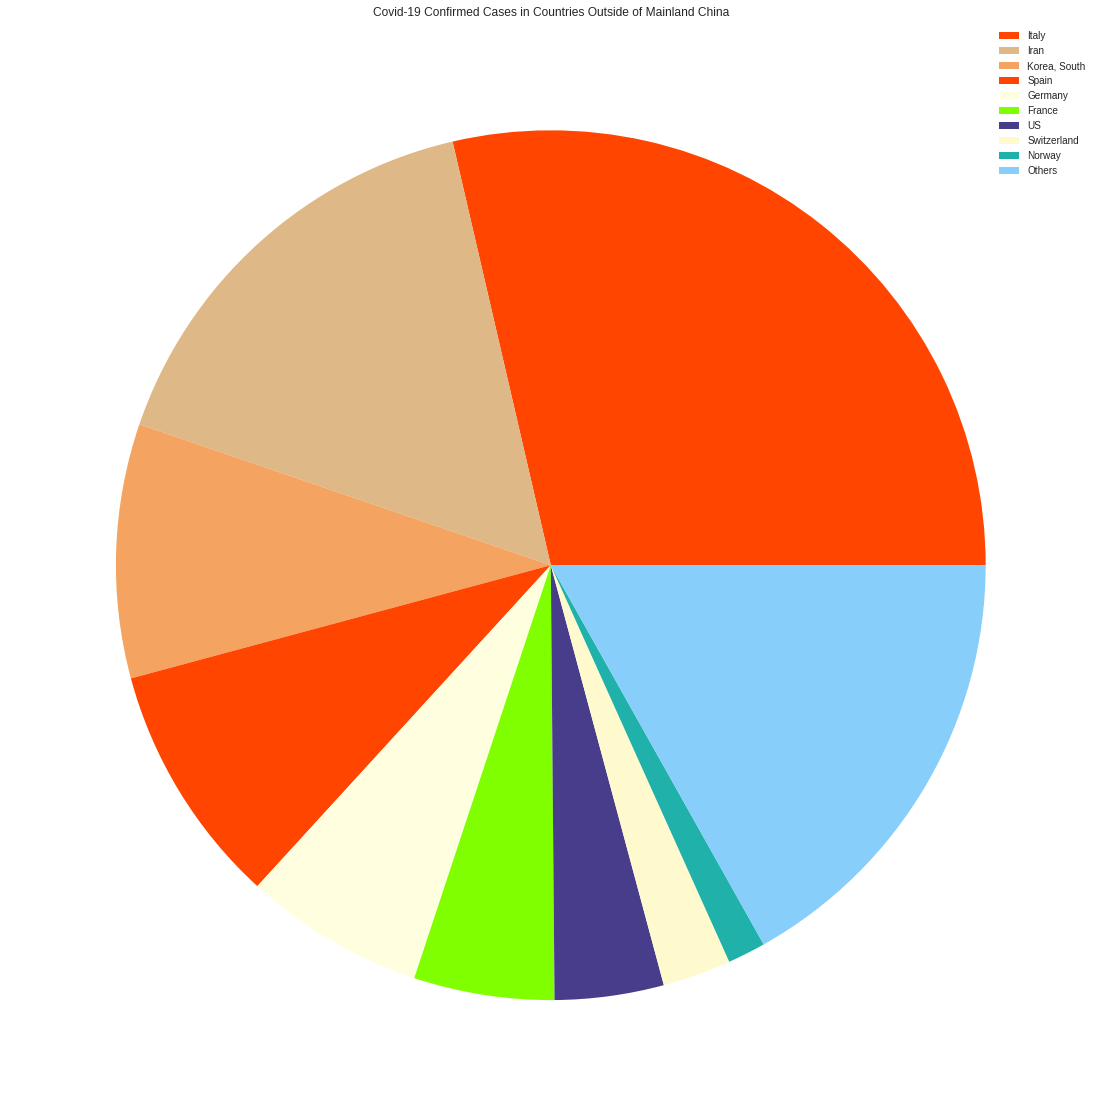

In [27]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,20))
plt.title('Covid-19 Confirmed Cases in Countries Outside of Mainland China')
plt.pie(visual_confirmed_cases[1:], colors=c)
plt.legend(visual_unique_countries[1:], loc='best')
plt.show()

In [28]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22, world_cases, test_size=0.2, shuffle=False) 

In [29]:
kernel = ['poly', 'sigmoid', 'rbf']
c = [0.01, 0.1, 1, 10]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
shrinking = [True, False]
svm_grid = {'kernel': kernel, 'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking}

svm = SVR()
svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
svm_search.fit(X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, estimator=SVR(), n_iter=40, n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 10],
                                        'epsilon': [0.01, 0.1, 1],
                                        'gamma': [0.01, 0.1, 1],
                                        'kernel': ['poly', 'sigmoid', 'rbf'],
                                        'shrinking': [True, False]},
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [30]:
svm_search.best_params_


{'shrinking': True, 'kernel': 'poly', 'gamma': 0.1, 'epsilon': 0.01, 'C': 0.01}

In [31]:
svm_confirmed = svm_search.best_estimator_
svm_pred = svm_confirmed.predict(future_forecast)

In [32]:
svm_confirmed

SVR(C=0.01, epsilon=0.01, gamma=0.1, kernel='poly')

In [33]:
svm_pred

array([ 30015.92268992,  30016.99082151,  30024.46774264,  30044.76224286,
        30084.2831117 ,  30149.43913871,  30246.63911343,  30382.2918254 ,
        30562.80606416,  30794.59061925,  31084.05428023,  31437.60583662,
        31861.65407797,  32362.60779383,  32946.87577373,  33620.86680721,
        34390.98968383,  35263.65319311,  36245.2661246 ,  37342.23726785,
        38560.97541239,  39907.88934777,  41389.38786353,  43011.87974921,
        44781.77379436,  46705.4787885 ,  48789.4035212 ,  51039.95678198,
        53463.54736039,  56066.58404597,  58855.47562827,  61836.63089683,
        65016.45864118,  68401.36765087,  71997.76671544,  75812.06462443,
        79850.67016739,  84119.99213386,  88626.43931337,  93376.42049548,
        98376.34446972, 103632.62002563, 109151.65595276, 114939.86104064,
       121003.64407883, 127349.41385686, 133983.57916427, 140912.54879061,
       148142.73152541, 155680.53615822, 163532.37147859, 171704.64627604,
       180203.76934014, 1

MAE: 25100.659197274468
MSE: 655231369.2254533


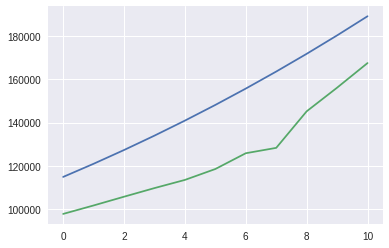

In [34]:
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(svm_test_pred)
plt.plot(y_test_confirmed)
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

In [35]:
from sklearn.metrics import accuracy_score

In [36]:
y_test_confirmed.shape

(11, 1)

In [37]:
svm_test_pred.reshape(11,1)

array([[114939.86104064],
       [121003.64407883],
       [127349.41385686],
       [133983.57916427],
       [140912.54879061],
       [148142.73152541],
       [155680.53615822],
       [163532.37147859],
       [171704.64627604],
       [180203.76934014],
       [189036.1494604 ]])

In [38]:
svm_test_pred

array([114939.86104064, 121003.64407883, 127349.41385686, 133983.57916427,
       140912.54879061, 148142.73152541, 155680.53615822, 163532.37147859,
       171704.64627604, 180203.76934014, 189036.1494604 ])

In [39]:
svm_test_pred.shape

(11,)

In [40]:
a=np.sum(y_train_confirmed)

In [41]:
b=mean_absolute_error(svm_test_pred, y_test_confirmed)

In [42]:
c=b/a
100-c*100

98.79151137527332